In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import requests
from pathlib import Path

from tqdm.notebook import tqdm

In [2]:
from dataclasses import dataclass

@dataclass
class ImageInfo:
    image_path: Path
    url: str
    img: cv.Mat|None = None

    def download(self) -> cv.Mat:
        if not self.image_path.exists():
            img_data = requests.get(self.url).content
            with open(self.image_path, 'wb') as f:
                f.write(img_data)
    
        # Opencv reads images in BGR.
        self.img = cv.imread(self.image_path)

    def rgb(self) -> cv.Mat:
        return cv.cvtColor(self.img, cv.COLOR_BGR2RGB)


class ImageCache:
    def __init__(self, base_path: str = './img/002-images'):
        self._base_path = Path(base_path)
        self._base_path.mkdir(parents=True, exist_ok=True)
        
        self._cache: dict[str, ImageInfo] = {
            'pluto': ImageInfo( # https://plus.nasa.gov/video/the-year-of-pluto/
                image_path=self._base_path / 'pluto.png',
                url='https://plus.nasa.gov/wp-content/uploads/2023/08/nasaplus_14_TheYearofPlutoHorizontal-Hero-16_9-Without-Title.png?w=1024',
            ),
        }
        for _, img in tqdm(self._cache.items(), desc="Downloading images"):
            img.download()

    def images(self):
        """Return all the image names registered."""
        return self._cache.keys()

    def __getitem__(self, img_name: str) -> ImageInfo:
        """Allow dictionary-like access to loaded images."""
        if img_name not in self._cache:
            self.load_img(img_name)
        return self._cache[img_name]


CACHE = ImageCache()

In [3]:
CACHE.images()

dict_keys(['pluto'])

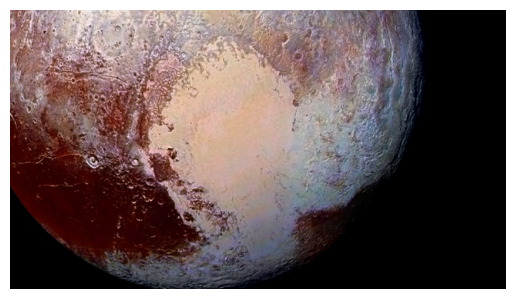

In [4]:
plt.imshow(CACHE['pluto'].rgb())
plt.axis('off')    
plt.show()

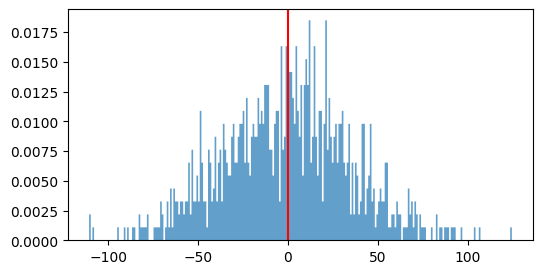

In [5]:
# See
# https://github.com/seafoodfry/numerical-analysis/blob/main/stats/basics/01-continuous-distributions.ipynb

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

noise_sigma = 35

ax.axvline(x=0, color='r')

# NOTE: don't center the noise around a value like 256//2.
# If you do, even a small variance will wash everything out because you are just adding 123(-ish)
# to the entire picture.
r = np.random.normal(0, noise_sigma, (1_000))
ax.hist(r, bins=256, density=True, histtype="stepfilled", alpha=0.7)

plt.show()

In [6]:
_example_noise = np.random.normal(50, 10, (3, 2))
_example_noise

array([[62.60093393, 55.82740743],
       [23.12898301, 45.27863192],
       [63.37549061, 53.97832795]])

In [7]:
_example_noise.astype(np.uint8)

array([[62, 55],
       [23, 45],
       [63, 53]], dtype=uint8)

In [8]:
def img_with_gaussian_noise(image: np.ndarray, noise_sigma: int = 5) -> np.ndarray:
    noise = np.random.normal(0, noise_sigma, image.shape).astype(np.uint8)
    return cv.add(image, noise)

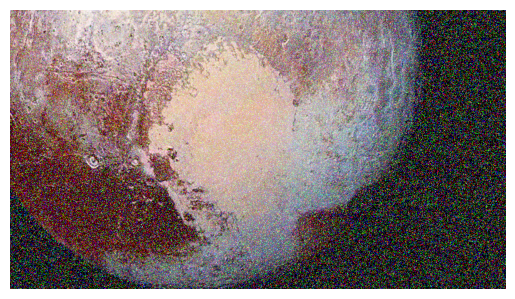

In [9]:
noisy_pluto = img_with_gaussian_noise(CACHE['pluto'].img, noise_sigma=1)
img_rgb = cv.cvtColor(noisy_pluto, cv.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis('off')    
plt.show()

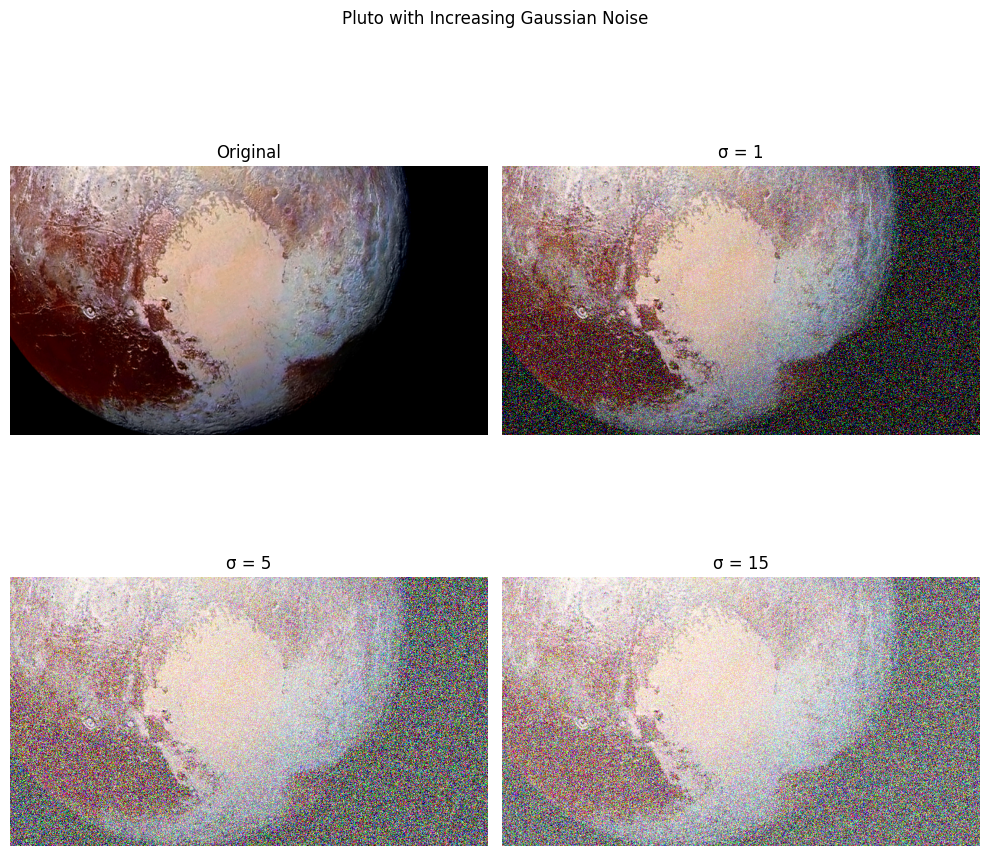

In [10]:
# Create a figure with 2x2 subplots.
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Pluto with Increasing Gaussian Noise', fontsize=12)

# Original image.
axes[0, 0].imshow(CACHE['pluto'].rgb())
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

# Add noise with increasing sigma values.
noise_levels = [1, 5, 15]
positions = [(0, 1), (1, 0), (1, 1)]  # Row, column positions for the noisy images.

for (row, col), sigma in zip(positions, noise_levels):
    noisy_img = img_with_gaussian_noise(CACHE['pluto'].img, noise_sigma=sigma)
    rgb_img = cv.cvtColor(noisy_img, cv.COLOR_BGR2RGB)
    
    axes[row, col].imshow(rgb_img)
    axes[row, col].set_title(f'σ = {sigma}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()